In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

/home/nakagawa/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [3]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,-41.391300,-19.525230,-41.098103,-40.247326,8.594010,16.886126
1,-23.017810,-37.092327,32.698044,1.198529,-7.665591,-26.310192
2,-25.394966,-44.099842,-50.211735,-58.358400,23.554977,-7.026921
3,-3.719642,33.317510,-86.934020,-88.753174,-1.316395,-32.161095
4,-12.965935,-19.494660,-0.595499,12.329179,2.745328,-19.452412


In [4]:
# min-max normalization
predict = predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
predict = predict.apply(lambda x: x / x.sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [5]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,0.000000,0.166199,0.002229,0.008695,0.379926,0.442952,0.442952,5,Walking,Walking
1,0.086685,0.000000,0.429837,0.235833,0.181239,0.066407,0.429837,2,Sitting,Sitting
2,0.174767,0.075597,0.043192,0.000000,0.434292,0.272152,0.434292,4,Upstairs,Upstairs
3,0.240921,0.345856,0.005154,0.000000,0.247730,0.160339,0.345856,1,Jogging,Jogging
4,0.082087,0.000000,0.237624,0.400129,0.279629,0.000531,0.400129,3,Standing,Standing
5,0.138359,0.233161,0.053717,0.000000,0.145151,0.429613,0.429613,5,Walking,Walking
6,0.399073,0.104462,0.010591,0.000000,0.304315,0.181560,0.399073,0,Downstairs,Downstairs
7,0.378500,0.132103,0.018062,0.000000,0.283365,0.187970,0.378500,0,Downstairs,Downstairs
8,0.218452,0.332881,0.000000,0.069409,0.232382,0.146876,0.332881,1,Jogging,Jogging
9,0.060885,0.248217,0.045822,0.000000,0.238503,0.406573,0.406573,5,Walking,Walking


Accuracy:  0.9501031929100401


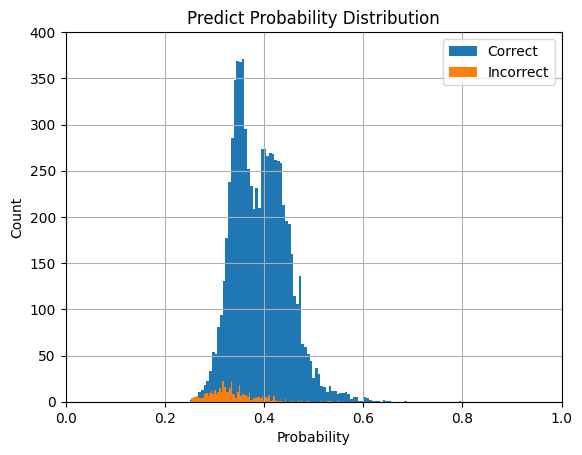

In [6]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [7]:
df['predict_probability'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.389657
std       0.055714
min       0.251131
max       0.797819
median    0.385022
Name: predict_probability, dtype: float64

In [8]:
thresholds = [0, 0.3, 0.35, 0.4, 0.5]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    cm_df = pd.DataFrame(cm, index=LABELS[:len(cm)], columns=LABELS[:len(cm)])
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        linewidths=0.5,
        cmap="Blues",
        cbar=False,
        annot_kws={"size": 14},
        square=True,
    )
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_24455/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.00,0.950103,1.000000,0.000000,0.000000
0.30,0.959940,0.969771,0.634538,0.030229
0.35,0.977793,0.727085,0.876335,0.272915
0.40,0.986293,0.416292,0.924293,0.583708
0.50,0.976096,0.030472,0.949286,0.969528


# process to gaussian

Before standardization
std: 0.0557142025069659
--- After standardization ---
std: 1.0


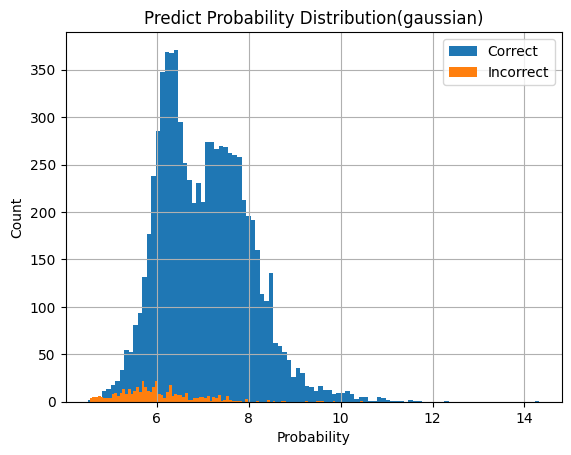

In [9]:
print("Before standardization")
std = df["predict_probability"].std()
print(f"std: {std}")
df["predict_probability_gaussian"] = df["predict_probability"].apply(lambda x: x / std)
print("--- After standardization ---")
std = df["predict_probability_gaussian"].std()
print(f"std: {std}")
df.loc[df.true_label==df.predict_label, 'predict_probability_gaussian'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_gaussian'].hist(bins=100)
plt.title('Predict Probability Distribution(gaussian)')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [10]:
thresholds = [0, 6, 8,  9, 10]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_gaussian'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_24455/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0,0.950103,1.000000,0.000000,0.000000
6,0.974651,0.852495,0.808230,0.147505
8,0.990499,0.153333,0.942787,0.846667
9,0.975207,0.029380,0.949343,0.970620
10,0.984375,0.007770,0.949835,0.992230


# process to torncurve

## 1 - (1 - x) ** 2

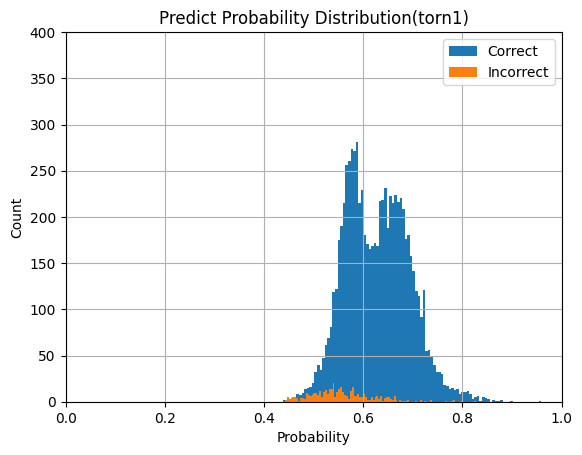

In [11]:
torn1_function = lambda x: 1-(1-x)**2
df["predict_probability_torn1"] = df["predict_probability"].apply(torn1_function)
df.loc[df.true_label==df.predict_label, 'predict_probability_torn1'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_torn1'].hist(bins=100)
plt.title('Predict Probability Distribution(torn1)')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [12]:
thresholds = [0, 0.5, 0.6, 0.7, 0.8]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_torn1'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_24455/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.0,0.950103,1.000000,0.000000,0.000000
0.5,0.957879,0.979968,0.569697,0.020032
0.6,0.981291,0.590506,0.905129,0.409494
0.7,0.988506,0.126745,0.944529,0.873255
0.8,0.985714,0.008498,0.949798,0.991502


## 1/ln(2) * ln(1+x)

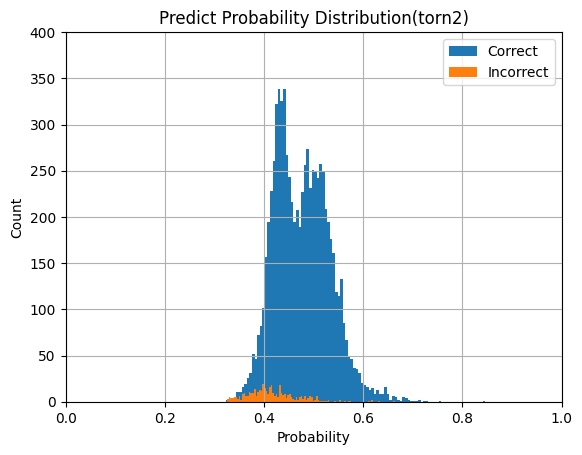

In [13]:
torn2_function = lambda x: (1/np.log(2))*np.log(1+x)
df["predict_probability_torn2"] = df["predict_probability"].apply(torn2_function)
df.loc[df.true_label==df.predict_label, 'predict_probability_torn2'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability_torn2'].hist(bins=100)
plt.title('Predict Probability Distribution(torn2)')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [14]:
thresholds = [0, 0.5, 0.55, 0.6, 0.65]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability_torn2'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_24455/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.00,0.950103,1.000000,0.000000,0.000000
0.50,0.989307,0.329246,0.930860,0.670754
0.55,0.984952,0.088746,0.946709,0.911254
0.60,0.963855,0.020153,0.949820,0.979847
0.65,0.976744,0.005220,0.949963,0.994780


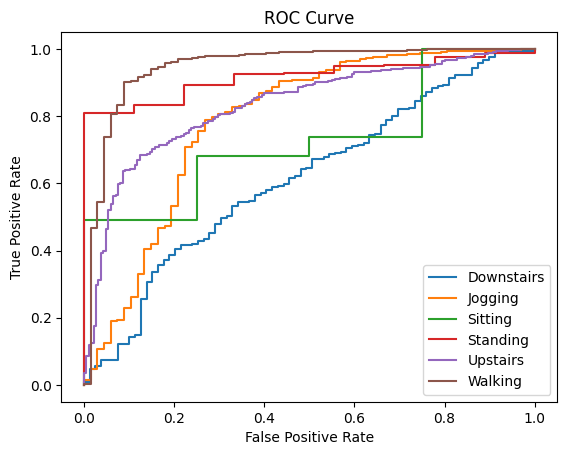

In [15]:
from sklearn.metrics import roc_curve

LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
for label in LABELS:
    fpr, tpr, thresholds = roc_curve(df.loc[df.predict_label==label, 'true_label'], df.loc[df.predict_label==label, "predict_probability"], pos_label=label)
    plt.plot(fpr, tpr, label=label)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()